# Import Libraries and Dataset

In [23]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from collections import defaultdict

import plotly.express as px
import plotly.graph_objects as go

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [24]:
raw_df = pd.read_csv('train-balanced-sarcasm.csv')
raw_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


# EDA

## Extracting the relevant columns

In [25]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [26]:
raw_df.isnull().sum()
raw_df.dropna(inplace=True)

In [27]:
# filter out the sarcastic comments
sarcastic_comments = raw_df[raw_df['label'] == 1]

# filter out the non-sarcastic comments
n_sarcastic_comments = raw_df[raw_df['label'] == 0]

In [28]:
# sub reddit in sarcastic comments
sarcastic_comments['subreddit'].value_counts().head(10)

AskReddit          26365
politics           23907
worldnews          16947
leagueoflegends    11407
pcmasterrace       10759
news               10193
funny               8099
pics                7823
todayilearned       7753
GlobalOffensive     7584
Name: subreddit, dtype: int64

In [29]:
# sub reddit in non-sarcastic comments
n_sarcastic_comments['subreddit'].value_counts().head(10)

AskReddit          39309
politics           15586
funny               9840
leagueoflegends     9627
worldnews           9429
pics                8329
pcmasterrace        8228
nfl                 6935
nba                 6698
news                6698
Name: subreddit, dtype: int64

In [30]:
# percentage of sarcastic comments in each subreddit in descending order
percent = sarcastic_comments['subreddit'].value_counts() / raw_df['subreddit'].value_counts()
percent.sort_values(ascending=False, inplace=True)
percent.dropna(inplace=True)
percent

0x10c               1.000000
helpmebuildapc      1.000000
LumiaLovers         1.000000
Luna_Lovewell       1.000000
M43                 1.000000
                      ...   
magicskyfairy       0.033333
pumparum            0.025641
ledootgeneration    0.022727
ACTrade             0.019608
friendsafari        0.014085
Name: subreddit, Length: 8993, dtype: float64

In [31]:
# comments in each subreddit in descending order
comments = raw_df['subreddit'].value_counts()
comments.sort_values(ascending=False, inplace=True)

# filter out the subreddits with more than 5000 comments
comments_5000 = comments[comments > 5000]

# list of subreddits with more than 5000 comments
listcomments_5000 = comments_5000.index.tolist()


In [32]:
percent_5000 = percent[percent.index.isin(listcomments_5000)]
percent_5000 = percent_5000.reset_index()
percent_5000.columns = ['subreddit', 'percentage']
percent_5000


,subreddit,percentage
0,creepyPMs,0.784303
1,worldnews,0.642516
2,atheism,0.639555
3,TumblrInAction,0.609766
4,politics,0.605348
5,news,0.603457
6,technology,0.599965
7,pcmasterrace,0.566651
8,AdviceAnimals,0.560822
9,GlobalOffensive,0.552045


## Visualizing the data

In [33]:
# graph of the percentage of sarcastic comments in each subreddit with more than 5000 comments
fig = px.bar(percent_5000, x='subreddit', y='percentage', title='Percentage of Sarcastic Comments in Each Subreddit with More Than 5000 Comments')
# add labels above the bars
fig.update_traces(texttemplate='%{y:.2%}', textposition='outside')
fig.show()

In [34]:
# graph of the number of comments in each subreddit with more than 5000 comments
fig = px.bar(comments_5000, x=comments_5000.index, y=comments_5000.values, title='Number of Comments in Each Subreddit with More Than 5000 Comments')
# add x and y axis labels
fig.update_xaxes(title_text='Subreddit')
fig.update_yaxes(title_text='Number of Comments')
# add labels above the bars
fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.show()

In [35]:
# compare the the number of comments in each subreddit with percentage of sarcastic comments in each subreddit 
fig = go.Figure()
fig.add_trace(go.Bar(x=percent_5000['subreddit'], y=percent_5000['percentage'], 
                     texttemplate='%{y:.2%}', textposition='outside', 
                     name='Percentage of Sarcastic Comments'))

fig.add_trace(go.Bar(x=comments_5000.index, y=comments_5000.values, 
                     texttemplate='%{y}', textposition='outside', 
                     name='Number of Comments', yaxis='y2'))
fig.update_layout(
    title='Percentage of Sarcastic Comments in Each Subreddit with More Than 5000 Comments',
    xaxis=dict(title='Subreddit'),
    yaxis=dict(title='Percentage of Sarcastic Comments'),
    yaxis2=dict(title='Number of Comments', overlaying='y', side='right'),
    legend=dict(x=0.5, y=1, xanchor='auto', yanchor='auto')
)
fig.show()


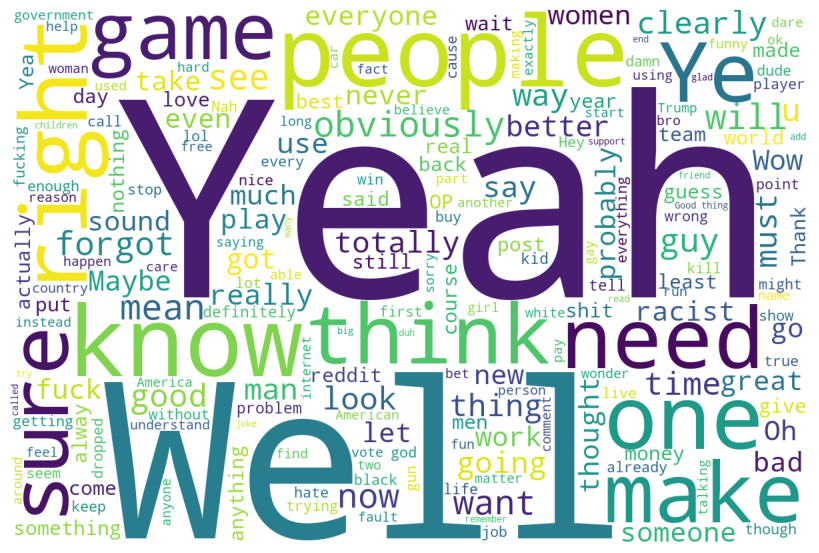

In [36]:
# word cloud of the sarcastic comments
wordcloud = WordCloud(width = 1200, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(sarcastic_comments['comment']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


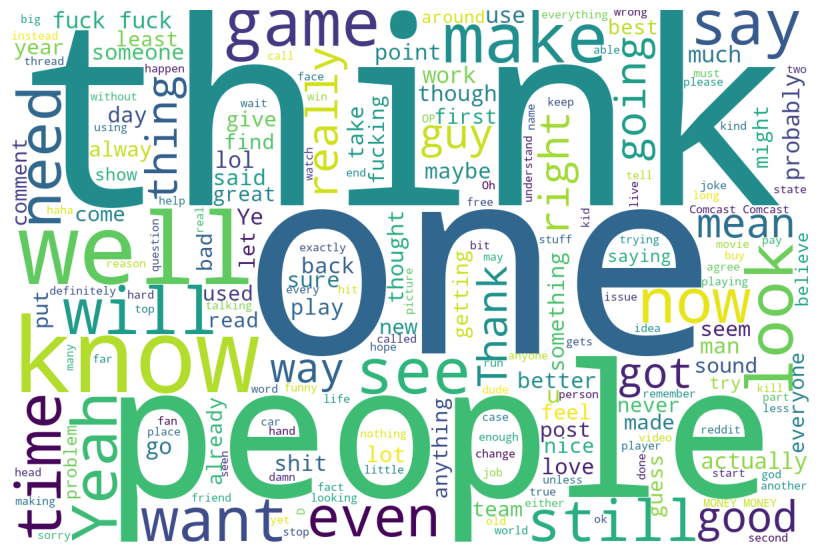

In [16]:
# word cloud of the non-sarcastic comments
wordcloud = WordCloud(width = 1200, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(' '.join(n_sarcastic_comments['comment']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

In [37]:
sub_df = raw_df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


In [38]:
# calculate the average score for sarcastic and non-sarcastic comments
sarcastic_comments['score'].mean().round(2), n_sarcastic_comments['score'].mean().round(2)


(6.4, 7.37)

In [39]:
# plot the average score for sarcastic and non-sarcastic comments in each subreddit
df = sarcastic_comments.groupby('subreddit')['score'].mean().round(2).sort_values(ascending=False).head(30).reset_index()
fig = px.bar(df, x='subreddit', y='score', title='Average Score for Sarcastic Comments in Each Subreddit')
fig.update_traces(texttemplate='%{y}', textposition='inside')
fig.show()


In [40]:
# plot the average score for non-sarcastic comments in each subreddit
df = n_sarcastic_comments.groupby('subreddit')['score'].mean().round(2).sort_values(ascending=False).head(30).reset_index()
fig = px.bar(df, x='subreddit', y='score', title='Average Score for Non-Sarcastic Comments in Each Subreddit')
fig.update_traces(texttemplate='%{y}', textposition='inside')
fig.show()

In [41]:
# plot the two lines: number of comments and number of sarcastic comments against time
df = raw_df.groupby('date')['label'].agg([np.size, np.sum])
df = df.reset_index()


fig = go.Figure()
fig.add_trace(go.Scatter(x=df['date'], y=df['size'], mode='lines', 
                         line=dict(color='blue'), name='Number of Comments'))
fig.add_trace(go.Scatter(x=df['date'], y=df['sum'], mode='lines', 
                         line=dict(color='red'), name='Number of Sarcastic Comments'))
fig.update_layout(title='Number of Comments and Sarcastic Comments Against Time')
fig.show()

# Process dataset

In [42]:
# type of each column
raw_df.dtypes

label              int64
comment           object
author            object
subreddit         object
score              int64
ups                int64
downs              int64
date              object
created_utc       object
parent_comment    object
dtype: object

In [43]:
# normalize the date column
raw_df['date'] = pd.to_datetime(raw_df['date'])
raw_df['date'] = raw_df['date'].dt.normalize()
raw_df['created_utc'] = pd.to_datetime(raw_df['created_utc'])
raw_df['created_utc'] = raw_df['created_utc'].dt.normalize()

In [48]:
# using BERT to predict the comments
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

# load the pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# create a dataset class
class SarcasmDataset(Dataset):
    def __init__(self, comments, labels, tokenizer, max_len):
        self.comments = comments
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = str(self.comments[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }
    
# create a data loader class
class SarcasmDataLoader:
    def __init__(self, dataset, batch_size, max_len, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.max_len = max_len
        self.num_workers = num_workers

    def create_data_loader(self):
        return DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers
        )
    
# create a BERT model class
class SarcasmModel(nn.Module):
    def __init__(self, n_classes):
        super(SarcasmModel, self).__init__()
        self.bert = model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)
    
# create a function to train the model
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

# create a function to evaluate the model
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# create a function to get the predictions
def get_predictions(model, data_loader):
    model = model.eval()
    comments = []
    predictions = []
    prediction_probs = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            comments.extend(d['comment'])
            predictions.extend(preds)
            prediction_probs.extend(outputs)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    return comments, predictions, prediction_probs

# create a function to plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True Label',
           xlabel='Predicted Label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    fmt = 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()

ImportError: cannot import name 'Mapping' from 'collections' (C:\Users\16920\anaconda3\Lib\collections\__init__.py)

In [49]:
# using BERT to predict the comments
# create a dataset
df = raw_df[['comment', 'label']]
df['label'] = df['label'].astype(int)
df = df.sample(frac=1).reset_index(drop=True)
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

# create a data loader
max_len = 160
batch_size = 16
num_workers = 2
n_classes = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_dataset = SarcasmDataset(
    comments=df_train.comment.to_numpy(),
    labels=df_train.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
)

train_data_loader = SarcasmDataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    max_len=max_len,
    num_workers=num_workers
)

val_dataset = SarcasmDataset(
    comments=df_val.comment.to_numpy(),
    labels=df_val.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
)

val_data_loader = SarcasmDataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    max_len=max_len,
    num_workers=num_workers
)

test_dataset = SarcasmDataset(
    comments=df_test.comment.to_numpy(),
    labels=df_test.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
)

test_data_loader = SarcasmDataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    max_len=max_len,
    num_workers=num_workers
)

# create a model
model = SarcasmModel(n_classes)
model = model.to(device)

# create a loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# create an optimizer
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# create a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# train the model
epochs = 10
history = defaultdict(list)
best_accuracy = 0

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader.create_data_loader(),
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader.create_data_loader(),
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc 

# evaluate the model
model.load_state_dict(torch.load('best_model_state.bin'))

test_acc, _ = eval_model(
    model,
    test_data_loader.create_data_loader(),
    loss_fn,
    device,
    len(df_test)
)

print(f'Test accuracy {test_acc.item()}')

C:\Users\16920\AppData\Local\Temp\ipykernel_54452\3698476643.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



NameError: name 'torch' is not defined

In [96]:
# vectorize the parent_comment and comment columns
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_parent = vectorizer.fit_transform(raw_df['parent_comment'])
X_comment = vectorizer.fit_transform(raw_df['comment'])

In [78]:
def create_dummy_columns(data, column_name):
    dummy_columns = pd.get_dummies(data[column_name], prefix=column_name, drop_first=True)
    data = pd.concat([data, dummy_columns], axis=1)
    data = data.drop(columns=[column_name])
    return data

处理 subreddit 和 author 这两个特征的一种常见方法是使用独热编码（One-Hot Encoding）或者标签编码（Label Encoding）。但是，由于这两个特征可能有很多唯一值，直接编码可能会导致特征维度过高。因此，我们可以考虑以下策略：

频率编码：对于每个类别，计算其在数据集中出现的频率，然后用这个频率来替代原来的类别。这种方法可以保留一些类别的信息，而不会增加特征的维度。

目标编码：对于每个类别，计算其对应的目标变量（在这里是讽刺情绪）的平均值，然后用这个平均值来替代原来的类别。这种方法可以捕获类别和目标变量之间的关系，但可能会导致过拟合。

降维：如果类别数量仍然过多，可以考虑使用主成分分析（PCA）或其他降维方法来减少特征的维度。

In [51]:
# Frequency encoding for 'subreddit'
subreddit_freq = raw_df['subreddit'].value_counts() / len(raw_df)
raw_df['subreddit'] = raw_df['subreddit'].map(subreddit_freq)

# Frequency encoding for 'author'
author_freq = raw_df['author'].value_counts() / len(raw_df)
raw_df['author'] = raw_df['author'].map(author_freq)


In [53]:
# Concatenate all the features in the raw_df with the TF-IDF vectors of the comment to create a combined feature matrix.
import pandas as pd
from scipy.sparse import csr_matrix

# Convert the TF-IDF vectors into DataFrames
X_parent_df = pd.DataFrame.sparse.from_spmatrix(X_parent)
X_comment_df = pd.DataFrame.sparse.from_spmatrix(X_comment)

NameError: name 'X_parent' is not defined

In [99]:
# use PCA to reduce the dimensionality of the TF-IDF vectors
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_parent_pca = pca.fit_transform(X_parent_df)
X_comment_pca = pca.fit_transform(X_comment_df)

# convert the PCA results into DataFrames
X_parent_pca_df = pd.DataFrame(X_parent_pca)
X_comment_pca_df = pd.DataFrame(X_comment_pca)

KeyboardInterrupt: 

In [ ]:
# Concatenate the DataFrames
X = pd.concat([raw_df, X_comment_pca_df], axis=1)

# Drop the 'parent_comment' and 'comment' columns
X = X.drop(columns=['comment', 'parent_comment'])

# drop the 'date' and 'created_utc' columns
X = X.drop(columns=['date', 'created_utc'])

# DROP NA
X.dropna(inplace=True)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns='label'), X['label'], test_size=0.2, random_state=0)

# Convert all feature names to string
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Check for duplicate feature names
duplicate_columns = X_train.columns[X_train.columns.duplicated()]
if duplicate_columns.any():
    print(f"Duplicate columns found: {duplicate_columns}")

# Rename duplicate feature names
X_train.columns = [f"{x}_{i}" if x in duplicate_columns else x for i, x in enumerate(X_train.columns)]
X_test.columns = [f"{x}_{i}" if x in duplicate_columns else x for i, x in enumerate(X_test.columns)]


In [ ]:
# Create a pipeline
pipe = Pipeline([
    ('model', LogisticRegression())
])

# Fit the model
pipe.fit(X_train, y_train)

# Make predictions
y_pred = pipe.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Train the model

In [91]:
X_train,X_test,Y_train,Y_test = train_test_split(raw_df['comment'].astype(str),raw_df['label'],random_state=0)
lr_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),('clf',  LogisticRegression(random_state= 0, solver='liblinear'))])
lr_clf.fit(X_train,Y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(random_state=0, solver='liblinear'))])

In [92]:
print(f"The accuracy on the training set is: {lr_clf.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {lr_clf.score(X_test,Y_test)}")

The accuracy on the training set is: 0.8169594685507297
The accuracy on the test set is:  0.7236805135084866


In [80]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(raw_df['comment'], raw_df['label'], test_size=0.2, random_state=42)

# create a pipeline
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# fit the model
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

In [81]:
# calculate the accuracy
accuracy_score(y_test, y_pred)

0.6932996957779921

In [26]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig = px.imshow(cm, labels=dict(x="Predicted", y="Actual", color="Count"), x=['Non-Sarcastic', 'Sarcastic'], y=['Non-Sarcastic', 'Sarcastic'])
fig.update_layout(title='Confusion Matrix')
fig.show()

In [27]:
# plot the ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', 
                         line=dict(color='blue'), name='ROC curve (area = %0.2f)' % roc_auc))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines',
                            line=dict(color='red', dash='dash'), name='Random'))
fig.update_layout(title='Receiver Operating Characteristic (ROC) Curve')
fig.update_xaxes(title_text='False Positive Rate')
fig.update_yaxes(title_text='True Positive Rate')
fig.show()

In [50]:
# plot the precision-recall curve
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

fig = go.Figure()
fig.add_trace(go.Scatter(x=recall, y=precision, mode='lines', 
                         line=dict(color='blue'), name='Precision-Recall curve'))
fig.update_layout(title='Precision-Recall Curve')
fig.update_xaxes(title_text='Recall')
fig.update_yaxes(title_text='Precision')
fig.show()


NameError: name 'y_test' is not defined

In [30]:
# xgboost model
from xgboost import XGBClassifier
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', XGBClassifier())
])

# fit the model
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# calculate the accuracy
accuracy_score(y_test, y_pred)

0.6794736711928966